# Пример использования Байесовского подхода для анализа данных

Для байесовского анализа мы будем использвать библиотеку PyMC3

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Пример 1 "Определение параметров линейной  зависимости"

В данном примере мы сгенерируем синтетические данные согласно следующей зависимости $y = k x + N(0, \sigma)$, где $N(0, \sigma)$ нормально распределенный белый шум снулевым математическим ожиданием и стандартным отклонением  $\sigma$.

### Истинные занчения параметров модели

In [2]:
sigma0 = 2.
k0 = 2.5

### Создаем тестовый набор данных

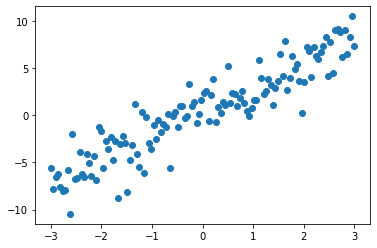

In [3]:
n = 128
x = np.linspace(-3, 3, n)
y = k0 * x + np.random.randn(n) * sigma0
plt.scatter(x,y)

### Создаем вероятностную модель

Задаем априорные вероятности для свободных параметров

In [4]:
linear_model = pm.Model()
with linear_model:
    sigma = pm.HalfNormal("$\sigma$", sigma = 10.)
    k = pm.Uniform("k",-10., 10.)

Затем описываем зависимость между $x$ и  $y$

In [5]:
with linear_model:
    y_expected = x * k
    y_obs = pm.Normal("y",mu = y_expected, sigma = sigma, observed = y)
linear_model

### Разыгрываем выборку из апостериорного распределения вероятностей

In [6]:
with linear_model:
    trace = pm.sample(20000, tune =5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, $\sigma$]
Sampling 4 chains, 0 divergences: 100%|██████████| 100000/100000 [00:11<00:00, 8470.66draws/s]


### Апроксимуруем апостериорное распределение вероятностей гистограммой

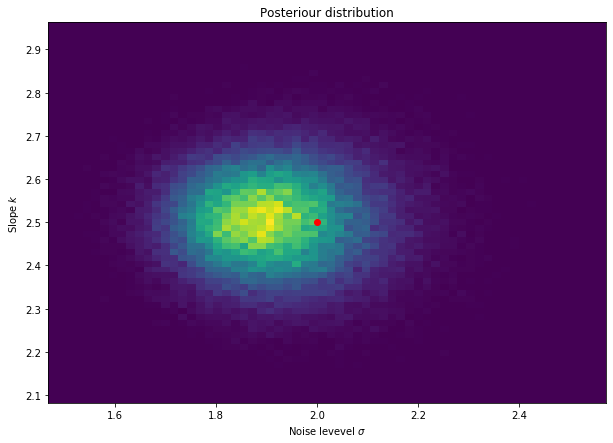

In [7]:
plt.figure(figsize=[10,7])
plt.hist2d(trace["$\sigma$"], trace["k"], bins = (64,64))[3]
plt.title("Posteriour distribution")
plt.xlabel("Noise levevel $\sigma$")
plt.ylabel("Slope $k$");
plt.scatter([sigma0],[k0], color = "red", marker="o") ;

## Строим маргинальные апостериорные распределения для параметров модели в виде гистограмм

Text(0.5, 0, 'Slope $k$')

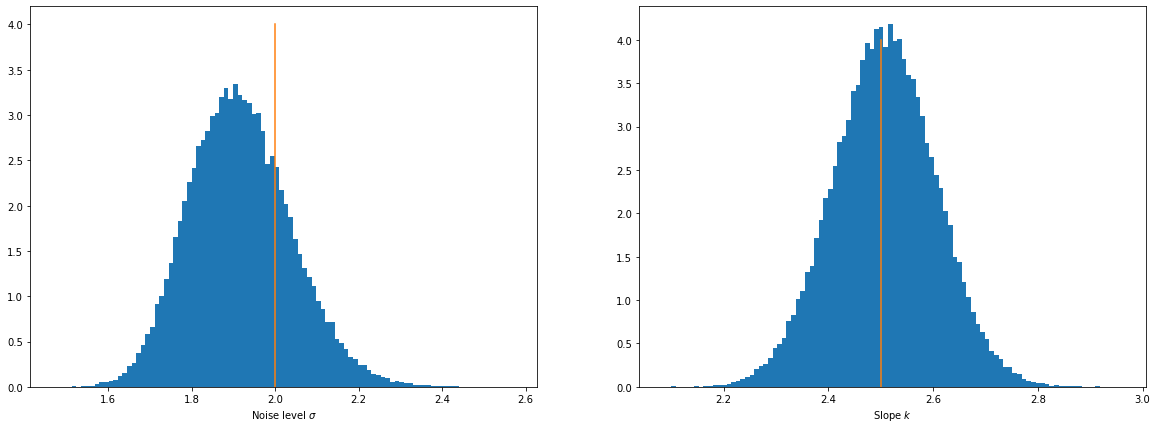

In [8]:
plt.figure(figsize=[20,7])
plt.subplot(1,2,1)
plt.hist(trace["$\sigma$"], bins =100, density=True);
plt.plot([sigma0,sigma0],[0.,4.0])
plt.xlabel("Noise level $\sigma$")
plt.subplot(1,2,2)
plt.hist(trace["k"],bins =100, density=True);
plt.plot([k0,k0],[0.,4.0])
plt.xlabel("Slope $k$")

 ### Строим апостереорное распределение для предсказаний модели

In [9]:

with linear_model:
    post_pred = pm.sample_posterior_predictive(trace, samples=10000)



/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:07<00:00, 1345.59it/s]


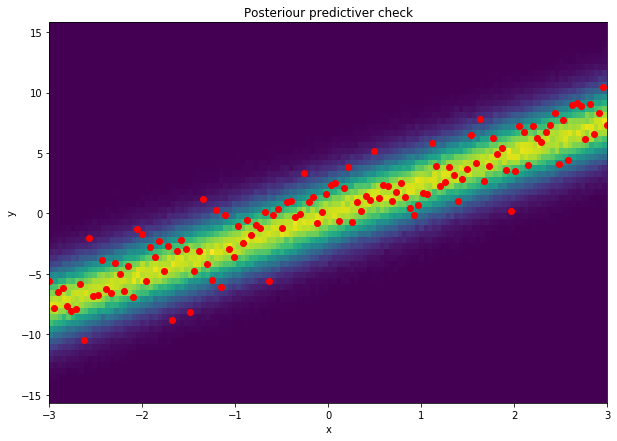

In [10]:

xx = np.broadcast_to(x, post_pred["y"].shape)
plt.figure(figsize=[10,7])
plt.hist2d(xx.ravel(), post_pred["y"].ravel(), bins = (128,64))[3]
plt.scatter(x,y, color ="red")
plt.title("Posteriour predictiver check")
plt.xlabel("x")
plt.ylabel("y");

## Пример 2 "Затухающие колебания"

В данном примере мы сгенерируем синтетические данные согласно следующей зависимости $y = A_0 \exp(-x/\tau)sin(2 \pi/P) + N(0, \sigma_0)$, где $N(0, \sigma_0)$ нормально распределенный белый шум снулевым математическим ожиданием и стандартным отклонением  $\sigma_0$.

### Истинные занчения параметров модели

In [11]:
tau0 = 3.
p0 = 1.5
a0 = 2.
sigma0 = 0.3

### Создаем тестовый набор данных

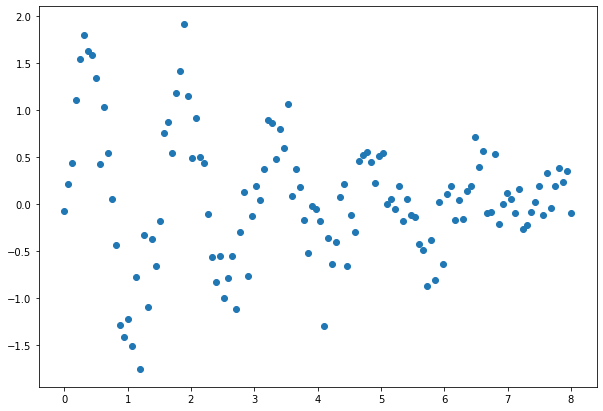

In [12]:
n = 128
x = np.linspace(0, 8, n)
y = a0 *np.exp(-x/tau0)* np.sin(2. * np.pi / p0 * x) + np.random.randn(n) * sigma0
plt.figure(figsize = [10,7])
plt.scatter(x,y);

In [18]:
model = pm.Model()
with model:
    #Априорные распределения свободных параметров
    sigma = pm.HalfNormal("$\sigma$", sigma = 10.)
    p = pm.Uniform("P",0., 10.)
    tau = pm.HalfNormal("$\\tau$", sigma = 10)
    a = pm.Uniform("A", 0., 10.)
    #Модельная зависимость y от x
    y_expected = a * pm.math.exp(-x/tau) * pm.math.sin(2. * np.pi / p * x) 
    #Имееющиеся наблюдения
    y_obs = pm.Normal("y",mu = y_expected, sigma = sigma, observed = y)

model

### Разыгрываем выборку из апостериорного распределения вероятностей

In [14]:
with model:
    trace = pm.sample(20000, tune =5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, $\tau$, P, $\sigma$]
Sampling 4 chains, 0 divergences: 100%|██████████| 100000/100000 [00:20<00:00, 4849.71draws/s]


## Строим маргинальные апостериорные распределения для параметров модели в виде гистограмм

Text(0.5, 0, 'Noise level $\\sigma$')

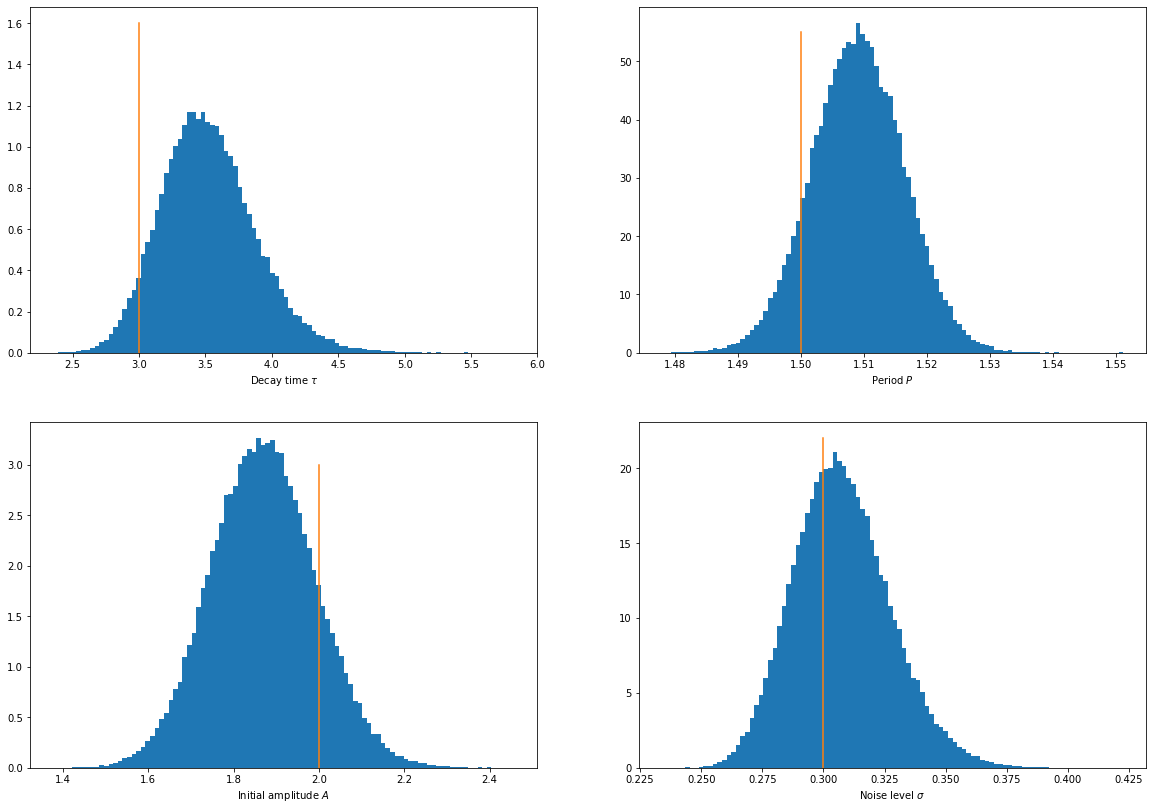

In [15]:
plt.figure(figsize=[20,14])
plt.subplot(2,2,1)
plt.hist(trace["$\\tau$"], bins =100, density=True);
plt.plot([tau0,tau0],[0.,1.6])
plt.xlabel("Decay time $\\tau$")
plt.subplot(2,2,2)
plt.hist(trace["P"],bins =100, density=True);
plt.plot([p0,p0],[0.,55.0])
plt.xlabel("Period $P$")
plt.subplot(2,2,3)
plt.hist(trace["A"],bins =100, density=True);
plt.plot([a0,a0],[0.,3.0])
plt.xlabel("Initial amplitude $A$")
plt.subplot(2,2,4)
plt.hist(trace["$\sigma$"],bins =100, density=True);
plt.plot([sigma0,sigma0],[0.,22.0])
plt.xlabel("Noise level $\sigma$")

## Строим 2D маргинальные апостериорные распределения для параметров модели в виде гистограмм

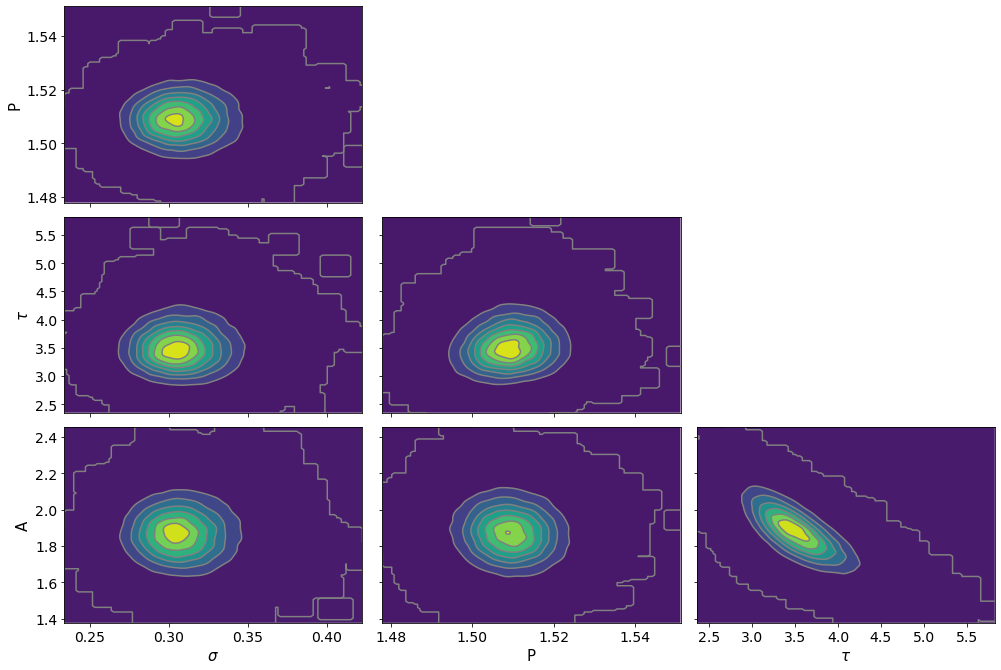

In [16]:
pm.pairplot(trace, kind = "kde");

 ### Строим апостереорное распределение для предсказаний модели

/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:08<00:00, 1226.96it/s]


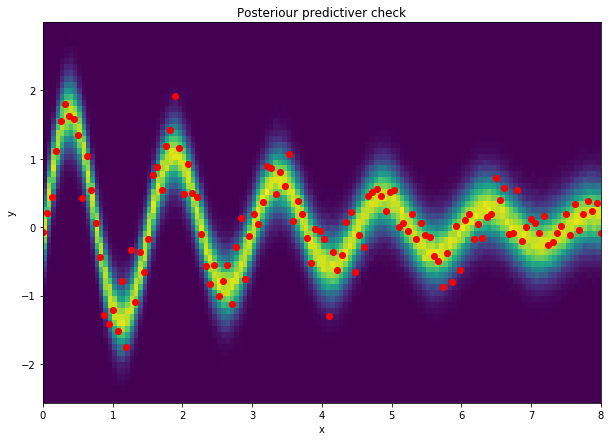

In [17]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=10000)
    
xx = np.broadcast_to(x, post_pred["y"].shape)
plt.figure(figsize=[10,7])
plt.hist2d(xx.ravel(), post_pred["y"].ravel(), bins = (128,64))[3]
plt.scatter(x,y, color ="red")
plt.title("Posteriour predictiver check")
plt.xlabel("x")
plt.ylabel("y");
